In [1]:
from __future__ import annotations

import time
from functools import reduce
from typing import Iterable, Tuple

import zentables

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from catboost import CatBoostClassifier
from joblib import Parallel, delayed
from lightgbm import LGBMClassifier

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier

from scipy.stats import kstest, chisquare

In [2]:
# Modify this constant to change the number of parallel jobs in this notebook

n_cores = 12

In [3]:
column_names = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education-num",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
    "native-country",
    "income",
]

In [4]:
adult_train = (
    pd.read_csv(
        "../data/adult.data",
        sep=", ",
        header=None,
        names=column_names,
        index_col=None,
        na_values="?",
    )
    .drop(columns=["fnlwgt", "education-num"])
    .dropna()
)

adult_train

c:\users\digic\synthbench\.synthbench\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,Assoc-acdm,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,HS-grad,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,HS-grad,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'capital-gain'}>],
       [<AxesSubplot:title={'center':'capital-loss'}>,
        <AxesSubplot:title={'center':'hours-per-week'}>]], dtype=object)

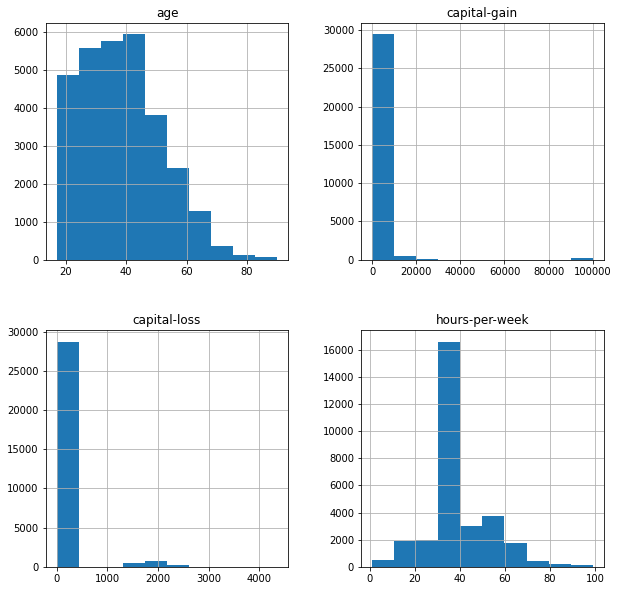

In [5]:
adult_train.hist(figsize=(10, 10))

In [6]:
adult_test = (
    pd.read_csv(
        "../data/adult.test",
        sep=", ",
        header=None,
        names=column_names,
        index_col=None,
        skiprows=1,
        na_values=["?"],
    )
    .drop(columns=["fnlwgt", "education-num"])
    .dropna()
    .reindex()
)

adult_test["income"] = adult_test["income"].str.slice(0, -1)
adult_test

c:\users\digic\synthbench\.synthbench\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,11th,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,Assoc-acdm,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
5,34,Private,10th,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16275,33,Private,Bachelors,Never-married,Prof-specialty,Own-child,White,Male,0,0,40,United-States,<=50K
16276,39,Private,Bachelors,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K
16278,38,Private,Bachelors,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K
16279,44,Private,Bachelors,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K


In [7]:
class MultiColumnLabelEncoder(TransformerMixin, BaseEstimator):
    def __init__(self):
        super(TransformerMixin, self).__init__()
        super(BaseEstimator, self).__init__()
        self.encoders_dict = None
        self.columns = None

    def fit(self, X: pd.DataFrame):
        self.encoders_dict = {
            col: LabelEncoder().fit(X[col]) for col in X.columns.to_list()
        }

    def transform(self, X: pd.DataFrame):
        return X.apply(lambda x: self.encoders_dict[x.name].transform(x))

    def fit_transform(self, X: pd.DataFrame):
        self.fit(X)
        return self.transform(X)

    def inverse_transform(self, X: pd.DataFrame) -> pd.DataFrame:
        return X.apply(lambda x: self.encoders_dict[x.name].inverse_transform(x))

In [8]:
def get_distributions(s: pd.Series):
    value_counts = s.value_counts(normalize=True)
    choices = value_counts.index.to_list()
    props = value_counts.to_list()

    return choices, props

In [9]:
class IRSSynthesizer(BaseEstimator):
    def __init__(self):
        self.fitted = False

    def fit(
        self,
        X: pd.DataFrame,
        base_cols: Iterable[str],
        categorical_cols: str | Iterable[str] | None = None,
        continuous_cols: str | Iterable[str] | None = None,
        gen_order: str | Iterable[str] | None = None,
    ):
        self.X = X
        self.n = len(X)
        self.cols = X.columns.to_series()

        if len(base_cols) < 2:
            raise ValueError("Please specify at least two base columns")

        self.base_cols = base_cols
        self.non_base_cols = self.cols[~self.cols.isin(base_cols)]

        dtypes = self.X[self.non_base_cols].dtypes

        if categorical_cols is None:
            self.categorical_cols = pd.concat(
                [
                    self.non_base_cols[dtypes == "object"],
                    self.non_base_cols[dtypes == "str"],
                ],
                axis=0,
            )

        if isinstance(categorical_cols, str):
            self.categorical_cols = [categorical_cols]

        if continuous_cols is None:
            self.continuous_cols = self.non_base_cols[
                ~self.non_base_cols.isin(self.categorical_cols)
            ]

        if isinstance(continuous_cols, str):
            self.continuous_cols = [continuous_cols]

        if gen_order is None:
            self.gen_order = pd.concat(
                [self.categorical_cols, self.continuous_cols], axis=0
            )
        else:
            gen_order = pd.Series(gen_order)
            if ~np.any(
                gen_order.isin(
                    pd.concat([self.categorical_cols, self.continuous_cols], axis=0)
                )
            ):
                raise ValueError(
                    "There are column(s) specified in gen_order that are not specified in either categorical_cols or continous_cols!"
                )

            self.gen_order = gen_order

        self.encoded_X = X.copy()
        self.all_cat_cols = pd.concat(
            [pd.Series(self.base_cols), self.categorical_cols], axis=0
        )

        self.label_encoder = MultiColumnLabelEncoder()

        if len(self.categorical_cols) > 0:
            self.label_encoder.fit(self.X[self.all_cat_cols])
            self.encoded_X.loc[:, self.all_cat_cols] = self.label_encoder.transform(
                self.encoded_X.loc[:, self.all_cat_cols]
            )

        self.fitted = True

    def generate(
        self,
        size: int = None,
        pct: float = 1.0,
        min_samples_leaf: int = 50,
        encode: bool = True,
        verbose: bool = True,
    ):

        if not self.fitted:
            raise ValueError("Please fit a dataset first!")

        if pct - 1.0 > 1e-7 or 0.0 - pct > 1e-7:
            raise ValueError("Please specify a number for pct between 0 and 1")

        size = size or self.n

        sampled = self.encoded_X.sample(frac=pct, replace=False).reset_index()

        ### Begin synthesizing:
        synthesized = pd.DataFrame()

        ### First, generate base columns
        synthesized[self.base_cols[0]] = self._gen_series(
            sampled[self.base_cols[0]], size
        )

        for i in range(1, len(self.base_cols)):
            lookup = (
                sampled.groupby(self.base_cols[:i], observed=True)[self.base_cols[i]]
                .apply(self._get_distributions)
                .to_dict()
            )

            synthesized[self.base_cols[i]] = 0

            synthesized[self.base_cols[i]] = synthesized.groupby(
                self.base_cols[:i], observed=True
            )[self.base_cols[i]].transform(
                lambda x: np.random.choice(
                    lookup[x.name][0], size=len(x), replace=True, p=lookup[x.name][1]
                )
            )

        generated_cols = synthesized.columns.to_list()

        ### Now, generate each subsequent column in order
        for curr_col in self.gen_order:

            if verbose:
                print(f"Generated: {generated_cols}, Generating: {curr_col}")

            # Build a decision tree classifier for categorical columns,
            # using `min_samples_leaf` as smoothing parameter
            if curr_col in self.categorical_cols:
                clf = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
                clf.fit(sampled[generated_cols], sampled[curr_col])
                probs = clf.predict_proba(synthesized[generated_cols])
                synthesized[curr_col] = np.apply_along_axis(
                    lambda x: np.random.choice(clf.n_classes_, p=x), axis=1, arr=probs
                )

            # Build a decision tree regressor for continuous columns,
            # using `min_samples_leaf` as smoothing parameter
            else:
                reg = DecisionTreeRegressor(min_samples_leaf=min_samples_leaf)
                reg.fit(sampled[generated_cols], sampled[curr_col])
                preds = reg.predict(synthesized[generated_cols])
                synthesized[curr_col] = preds

                # Apply percentile smoothing
                for p in range(0, 101):
                    percentile_values = np.percentile(preds, p)
                    kde = KernelDensity()
                    kde.fit(percentile_values.reshape(-1, 1))
                    loc = (synthesized[curr_col] >= np.min(percentile_values)) & (
                        synthesized[curr_col] <= np.max(percentile_values)
                    )
                    synthesized.loc[loc, curr_col] = kde.sample(int(np.sum(loc)))

            generated_cols.append(curr_col)

        ### Output the generated
        output = synthesized[self.cols].copy()

        if encode:
            output[self.all_cat_cols] = self.label_encoder.inverse_transform(
                synthesized[self.all_cat_cols]
            )

        return output

    def _gen_series(self, s: pd.Series, size: int | None = None):
        size = size or len(s)
        distribution = s.value_counts(normalize=True)
        choices = distribution.index

        return np.random.choice(choices, size, replace=True, p=distribution)

    def _get_distributions(self, s: pd.Series):
        value_counts = s.value_counts(normalize=True)
        choices = value_counts.index.to_list()
        props = value_counts.to_list()

        return choices, props

In [10]:
synthesizer = IRSSynthesizer()
synthesizer.fit(adult_train, base_cols=["sex", "age"])

generated = synthesizer.generate()

Generated: ['sex', 'age'], Generating: workclass
Generated: ['sex', 'age', 'workclass'], Generating: education
Generated: ['sex', 'age', 'workclass', 'education'], Generating: marital-status
Generated: ['sex', 'age', 'workclass', 'education', 'marital-status'], Generating: occupation
Generated: ['sex', 'age', 'workclass', 'education', 'marital-status', 'occupation'], Generating: relationship
Generated: ['sex', 'age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship'], Generating: race
Generated: ['sex', 'age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race'], Generating: native-country
Generated: ['sex', 'age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'native-country'], Generating: income
Generated: ['sex', 'age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'native-country', 'income'], Generating: capital-gain
Generated: ['sex', 'age', 'workclass', 'edu

In [11]:
generated

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,36,Self-emp-not-inc,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,8970.517857,-0.243729,51.963636,United-States,>50K
1,22,Self-emp-not-inc,HS-grad,Never-married,Other-service,Not-in-family,White,Male,5320.796610,-1.596005,36.471429,United-States,>50K
2,39,Private,Some-college,Divorced,Other-service,Unmarried,Black,Female,108.283333,1.081451,37.523810,United-States,<=50K
3,47,Private,Bachelors,Married-civ-spouse,Exec-managerial,Husband,Asian-Pac-Islander,Male,4444.354839,-0.332650,43.625000,South,>50K
4,18,Private,HS-grad,Never-married,Sales,Own-child,White,Female,691.515152,0.044536,27.420000,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30157,20,Private,HS-grad,Never-married,Other-service,Not-in-family,White,Male,81.656716,63.244186,36.471429,United-States,<=50K
30158,46,Without-pay,Some-college,Divorced,Adm-clerical,Not-in-family,White,Female,174.818182,48.343750,40.397436,United-States,<=50K
30159,23,Private,Some-college,Never-married,Machine-op-inspct,Not-in-family,Black,Male,1.194917,0.572894,39.271429,United-States,<=50K
30160,29,Private,12th,Never-married,Other-service,Unmarried,Black,Female,132.980000,0.626174,33.253012,United-States,<=50K


In [12]:
def generate_datasets(
    synthesizer: IRSSynthesizer,
    size: int | None = None,
    copies: int = 1,
    pct: float | List[float] = 1.0,
    min_samples_leaf: int | list[int] = 50,
    n_jobs: int = 1,
    **kwargs
):
    """
    Generates lists of lists of synthesized dataset from IRSSynthesizer.
    """

    if isinstance(pct, list) and isinstance(min_samples_leaf, list):
        raise ValueError("pct and min_samples_leaf cannot both be lists")

    if isinstance(pct, list):
        X_synths = [
            Parallel(n_jobs=n_jobs)(
                delayed(synthesizer.generate)(
                    size=size, pct=e, min_samples_leaf=min_samples_leaf, **kwargs
                )
                for _ in range(copies)
            )
            for e in pct
        ]

    if isinstance(min_samples_leaf, list):
        X_synths = [
            Parallel(n_jobs=n_jobs)(
                delayed(synthesizer.generate)(
                    size=size, pct=pct, min_samples_leaf=e, **kwargs
                )
                for _ in range(copies)
            )
            for e in min_samples_leaf
        ]

    if copies == 1:
        return list(map(lambda x: x[0], X_synths))

    return X_synths

In [13]:
generated_dataset_pcts = generate_datasets(
    synthesizer, copies=10, pct=[0.25, 0.5, 0.75, 1.0], n_jobs=n_cores, verbose=False
)
generated_dataset_msls = generate_datasets(
    synthesizer,
    copies=10,
    min_samples_leaf=[1, 50, 100, 200],
    n_jobs=n_cores,
    verbose=False,
)

In [14]:
def plot_distributions(
    X: pd.DataFrame,
    X_synths: List[pd.DataFrame],
    cols: Iterable[str],
    categorical: bool,
    subplot_size: int = 3,
) -> Tuple(plt.Figure, plt.Axes):
    nrows = len(X_synths) + 1
    ncols = len(cols)

    figsize = (subplot_size * ncols, subplot_size * nrows)

    fig, axes = plt.subplots(nrows, ncols, sharex="col", sharey="col", figsize=figsize)

    for i, df in enumerate([X] + X_synths):
        for j, col in enumerate(cols):
            if categorical:
                df[col].value_counts().plot.bar(
                    title=col if i == 0 else None, ax=axes[i][j]
                )
            else:
                df[col].plot.hist(title=col if i == 0 else None, ax=axes[i][j])

    return fig, axes

In [15]:
def compare_distributions(
    X: pd.DataFrame,
    X_synths: List[pd.DataFrame],
    categorical_cols: List[str] | None = None,
    continuous_cols: List[str] | None = None,
):
    cols = X.columns.to_series()
    dtypes = X.dtypes.astype(str)

    categorical_cols = categorical_cols or cols[dtypes.isin(["object", "str"])]
    continuous_cols = continuous_cols or cols[~cols.isin(categorical_cols)]

    fig, axes = plot_distributions(X, X_synths, categorical_cols, categorical=True)
    fig, axes = plot_distributions(X, X_synths, continuous_cols, categorical=False)

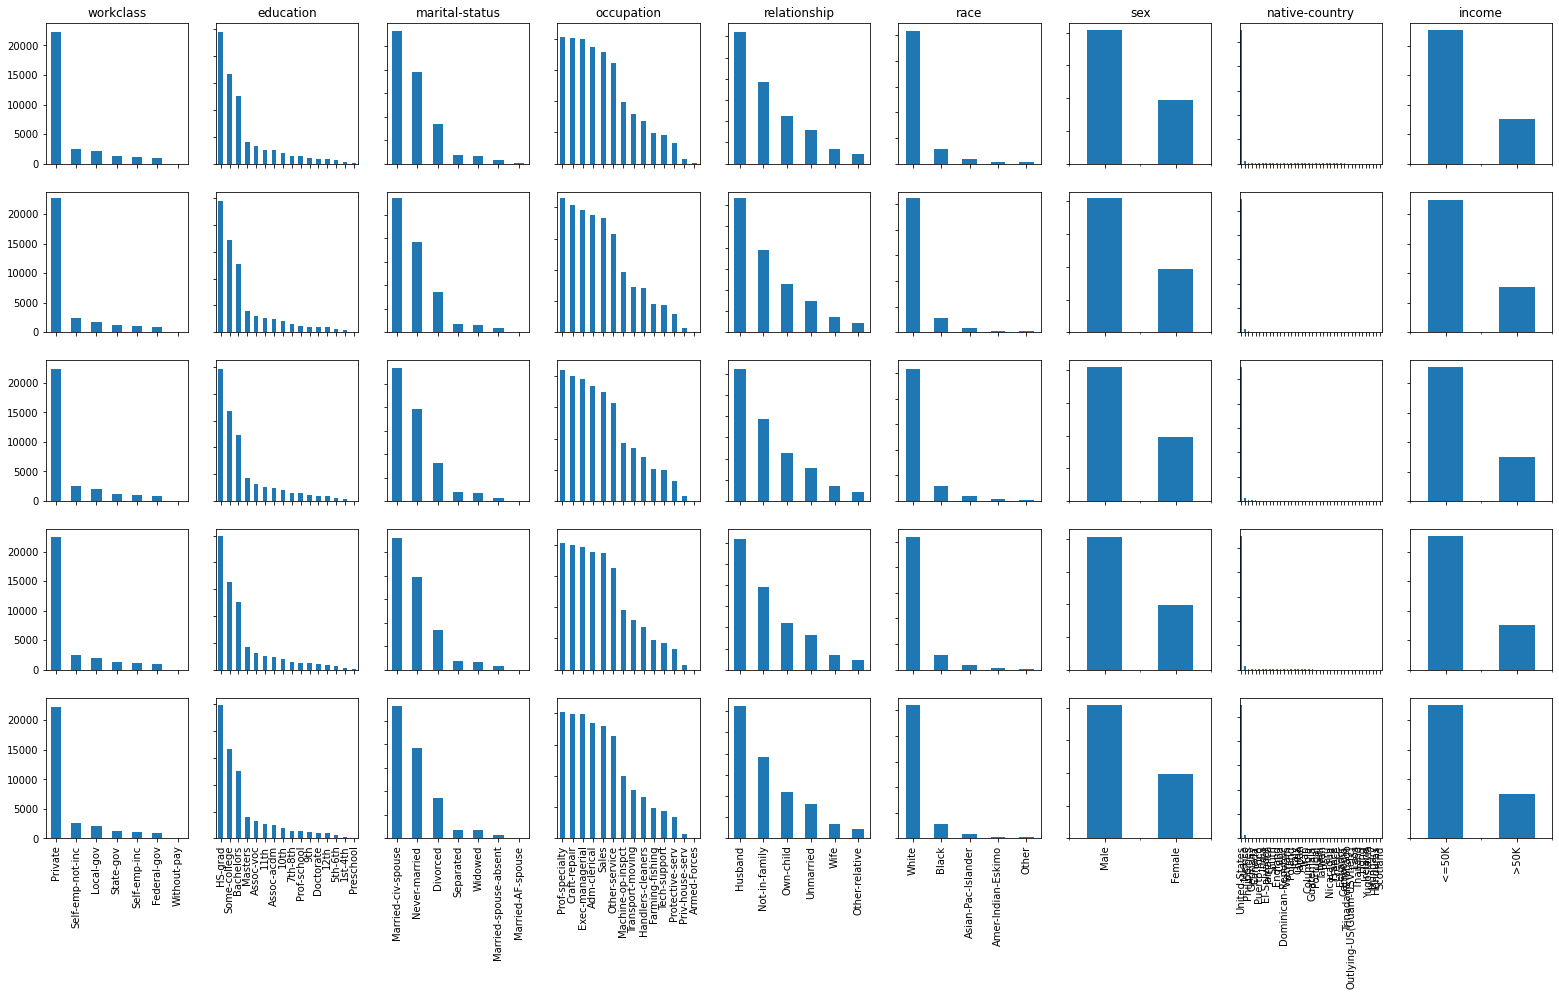

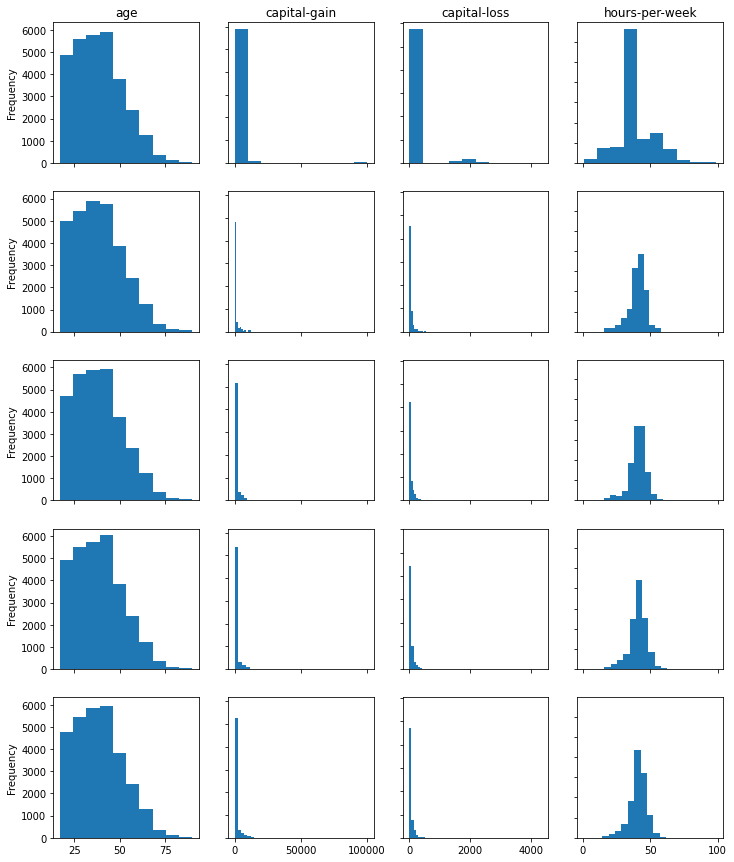

In [16]:
compare_distributions(synthesizer.X, [l[0] for l in generated_dataset_pcts])

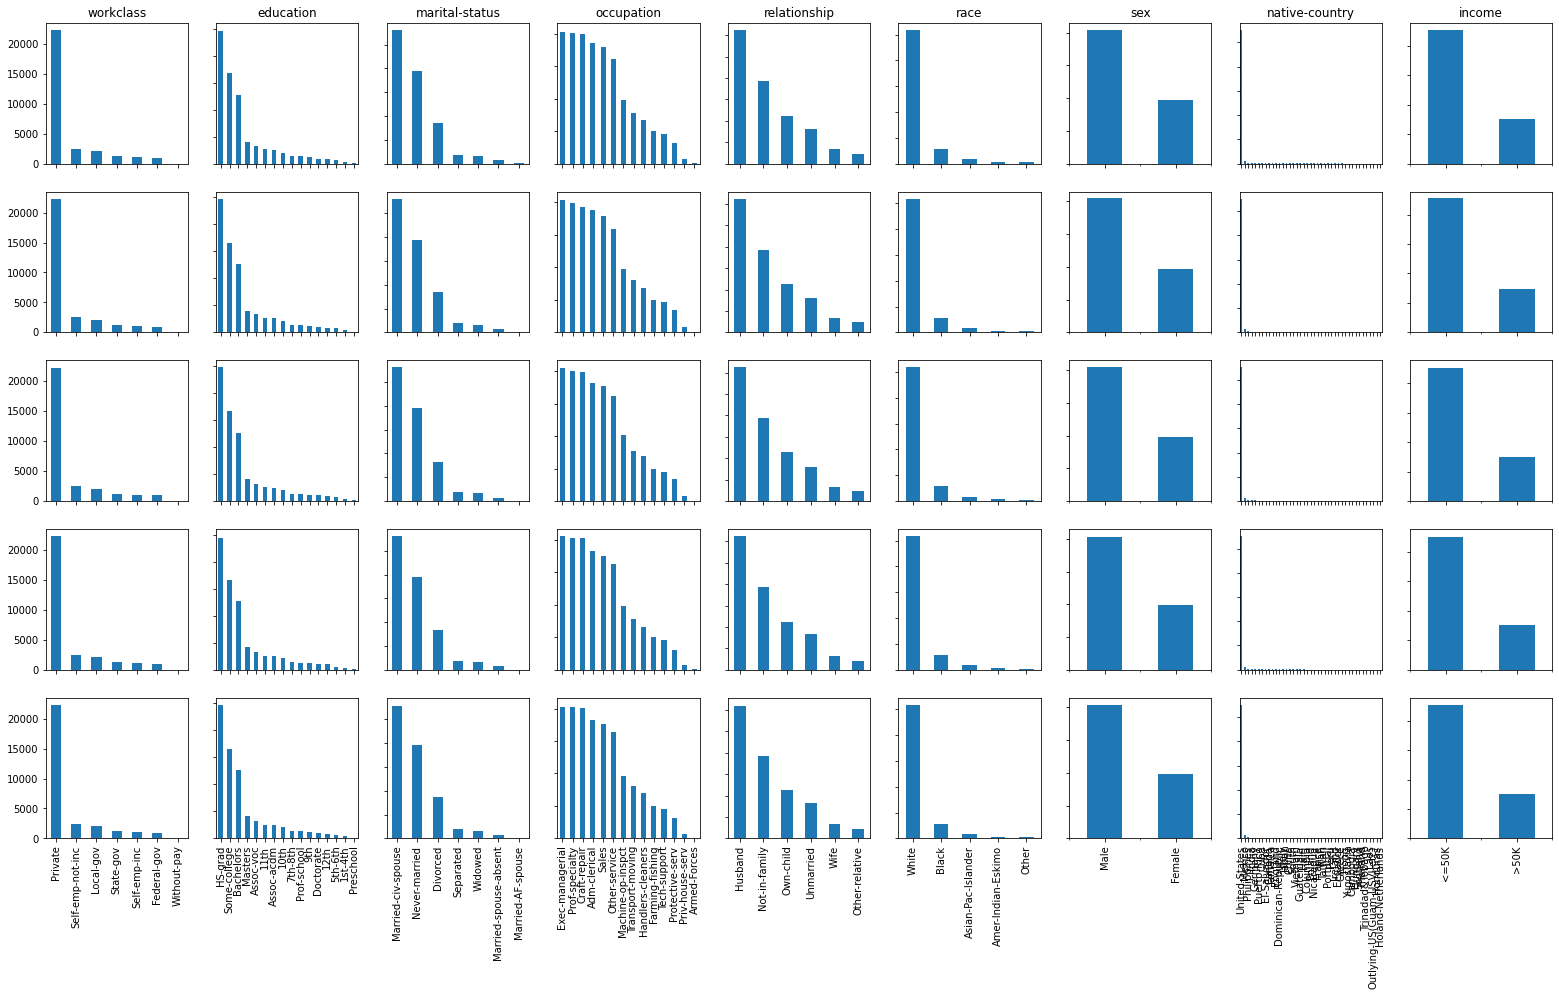

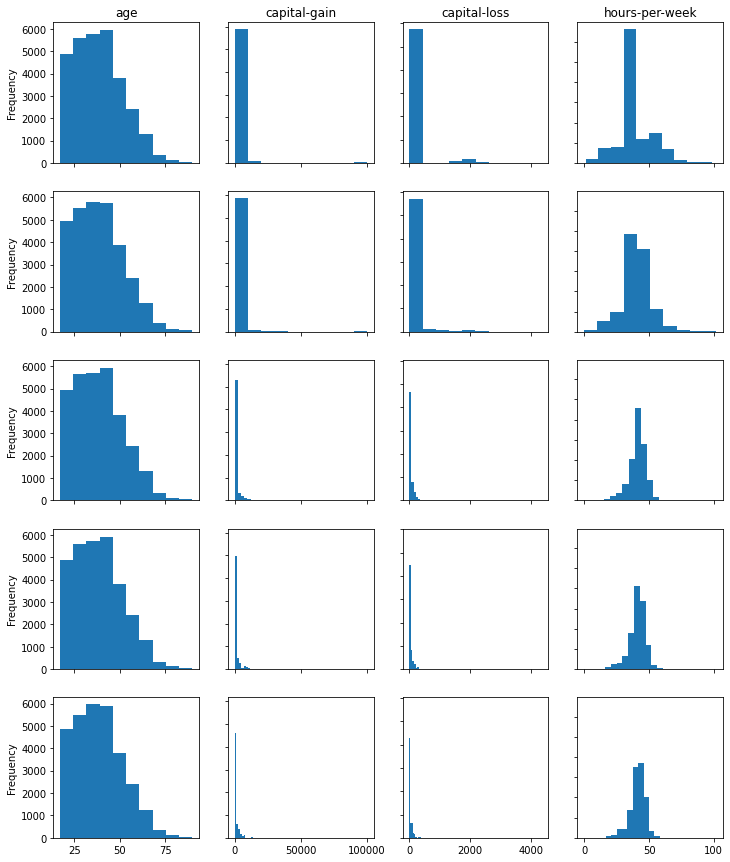

In [17]:
compare_distributions(synthesizer.X, [l[0] for l in generated_dataset_msls])

In [18]:
def encode_df(df, cols, enc):
    new_df = df.copy()
    new_df[cols] = enc.transform(new_df[cols])
    return new_df


encoded_dataset_pcts = [
    [encode_df(X, synthesizer.all_cat_cols, synthesizer.label_encoder) for X in row]
    for row in generated_dataset_pcts
]
encoded_dataset_msls = [
    [encode_df(X, synthesizer.all_cat_cols, synthesizer.label_encoder) for X in row]
    for row in generated_dataset_msls
]

In [19]:
categorical_cols = adult_train.columns[adult_train.dtypes == "object"].to_list()
continuous_cols = adult_train.columns[adult_train.columns.isin(categorical_cols)]

In [20]:
def compare_chi_square(df1, df2s, cols):
    results = {}

    for col in cols:

        p_values = []

        for df2 in df2s:

            df1_counts = df1[col].value_counts()
            df2_counts = df2[col].value_counts()

            if len(df1_counts) != len(df2_counts):
                p_values.append(np.nan)
                continue

            compare = pd.DataFrame({"0": df1_counts, "1": df2_counts}).sort_index()

            if compare.isna().any(axis=None) or (compare < 5).any(axis=None):
                p_values.append(np.nan)
                continue

            chisq = chisquare(compare["0"], compare["1"])
            p_values.append(chisq.pvalue)

        results[col] = p_values

    return pd.DataFrame(results)

In [21]:
def compare_kstest(df1, df2s, cols):
    return pd.DataFrame(
        {col: [kstest(df1[col], df2[col]).pvalue for df2 in df2s] for col in cols}
    )

In [22]:
compare_chi_square(synthesizer.encoded_X, encoded_dataset_pcts[0], categorical_cols)

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,income
0,1.614161e-10,1.020644e-07,2.985622e-12,2.811967e-07,2.047619e-06,4.654274e-03,0.300410,NaN,1.934045e-02
1,5.697903e-04,1.120145e-06,8.530115e-02,NaN,2.963410e-03,4.026412e-05,0.222096,NaN,1.446576e-01
2,5.203739e-01,1.654024e-07,7.099478e-17,1.168665e-03,1.309469e-02,2.455671e-03,0.308348,NaN,9.045639e-01
3,1.675705e-01,3.014980e-05,5.063151e-03,1.016456e-06,4.520341e-02,5.864334e-06,0.001259,NaN,1.686651e-02
4,3.836692e-07,1.658849e-02,2.172997e-02,5.614980e-04,7.322274e-04,2.042791e-01,0.376729,NaN,1.343088e-01
5,2.353759e-03,3.122951e-01,4.633438e-05,NaN,7.011510e-07,1.199805e-15,0.000239,NaN,6.244018e-11
6,7.567369e-09,5.449986e-08,1.558122e-22,3.519304e-06,6.907487e-10,5.642151e-03,0.138656,NaN,3.361626e-04
7,3.593258e-03,4.013825e-08,7.102376e-04,2.102943e-03,2.732506e-03,1.644806e-04,0.843915,NaN,2.333910e-02
8,NaN,3.081492e-09,1.168140e-03,8.462373e-09,1.409854e-03,1.791923e-03,0.000339,NaN,5.843887e-01
9,3.721230e-01,7.351981e-03,1.563248e-01,1.630996e-04,2.297799e-05,3.813527e-02,0.000242,NaN,9.893747e-01


In [23]:
compare_kstest(
    synthesizer.encoded_X,
    encoded_dataset_pcts[0],
    ["age", "capital-gain", "capital-loss"],
)

,age,capital-gain,capital-loss
0,0.824653,0.0,0.0
1,0.443543,0.0,0.0
2,0.104576,0.0,0.0
3,0.363718,0.0,0.0
4,0.200502,0.0,0.0
5,0.017378,0.0,0.0
6,0.004694,0.0,0.0
7,0.981863,0.0,0.0
8,0.830580,0.0,0.0
9,0.009337,0.0,0.0


In [24]:
def distribution_tests(
    X: pd.DataFrame,
    X_synths: List[List[pd.DataFrame]],
    param: str,
    param_values: list[float] | list[int],
    categorical_cols: list[str],
):

    continuous_cols = X.columns[~X.columns.isin(categorical_cols)]

    chisq_pvalue_avgs = {}
    chisq_pvalue_sigs = {}

    for param_value, df_list in zip(param_values, X_synths):
        index = f"{param}={param_value}"
        results = compare_chi_square(X, df_list, categorical_cols)
        chisq_pvalue_avgs[index] = results.mean(axis=0)
        chisq_pvalue_sigs[index] = results.lt(0.05).sum(axis=0)

    chisq_pvalue_avgs = pd.DataFrame(chisq_pvalue_avgs)
    chisq_pvalue_sigs = pd.DataFrame(chisq_pvalue_sigs)

    ks_pvalue_avgs = {}
    ks_pvalue_sigs = {}

    for param_value, df_list in zip(param_values, X_synths):
        index = f"{param}={param_value}"
        results = compare_kstest(X, df_list, continuous_cols)
        ks_pvalue_avgs[index] = results.mean(axis=0)
        ks_pvalue_sigs[index] = results.lt(0.05).sum(axis=0)

    ks_pvalue_avgs = pd.DataFrame(ks_pvalue_avgs)
    ks_pvalue_sigs = pd.DataFrame(ks_pvalue_sigs)

    return pd.concat(
        {"Chi-squared test": chisq_pvalue_avgs, "KS test": ks_pvalue_avgs},
        axis=0,
        names=["Test", "Column"],
    ), pd.concat(
        {"Chi-squared test": chisq_pvalue_sigs, "KS test": ks_pvalue_sigs},
        axis=0,
        names=["Test", "Column"],
    )

In [25]:
avg_pvalues, sig_pvalues = distribution_tests(
    synthesizer.encoded_X,
    encoded_dataset_pcts,
    "pct",
    [0.25, 0.5, 0.75, 1.0],
    categorical_cols,
)

sig_pvalues.zen.pretty().format(precision=0)

In [26]:
avg_pvalues, sig_pvalues = distribution_tests(
    synthesizer.encoded_X,
    encoded_dataset_msls,
    "mean_samples_leaf",
    [1, 50, 100, 200],
    categorical_cols,
)

sig_pvalues.zen.pretty().format(precision=0)

In [27]:
def test_model(X_train, y_train, X_test, y_test, model, cat_features):
    if model == "DecisionTree":
        clf = DecisionTreeClassifier()
        clf.fit(X_train, y_train)

    if model == "RandomForest":
        clf = RandomForestClassifier()
        clf.fit(X_train, y_train)

    if model == "LightGBM":
        clf = LGBMClassifier()
        clf.fit(X_train, y_train, categorical_feature=cat_features)

    if model == "CatBoost":
        clf = CatBoostClassifier()
        clf.fit(X_train, y_train, cat_features=cat_features, verbose=0)

    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1]

    return roc_auc_score(y_test, y_pred), average_precision_score(y_test, y_prob)

In [28]:
def modeling_tests(df_train_enc, df_test_enc, models=None):

    X_train = df_train_enc.drop(columns=["income"])
    y_train = df_train_enc["income"]

    X_test = df_test_enc.drop(columns=["income"])
    y_test = df_test_enc["income"]

    cat_features = X_train.columns[
        X_train.dtypes.astype(str).isin(["object", "str"])
    ].to_list()

    models = models or ["DecisionTree", "RandomForest", "LightGBM", "CatBoost"]
    auroc = []
    auprc = []

    for model in models:
        roc, prc = test_model(X_train, y_train, X_test, y_test, model, cat_features)
        auroc.append(roc)
        auprc.append(prc)

    return pd.DataFrame({"AUROC": auroc, "AUPRC": auprc}, index=models)

In [29]:
adult_test_encoded = encode_df(adult_test, categorical_cols, synthesizer.label_encoder)

In [30]:
def ml_experiments(
    X, X_synths, df_test_enc, param, param_values, models=None, n_jobs: int = 1
):

    results = {}

    results["Original"] = modeling_tests(X, df_test_enc, models)

    for param_value, encoded_Xs in zip(param_values, X_synths):
        index = f"{param}={param_value}"
        metrics = Parallel(n_jobs=n_jobs)(
            delayed(modeling_tests)(encoded_X, df_test_enc, models)
            for encoded_X in encoded_Xs
        )
        metrics = reduce(lambda x, y: x + y, metrics) / len(encoded_Xs)

        results[index] = metrics

    return pd.concat(results, axis=1)

In [31]:
def plot_metric(df, metric="AUPRC", figsize=(6, 4), dpi=300):
    to_plot = (
        df.xs(metric, axis=1, level=1)
        .melt(var_name="Condition", value_name=metric, ignore_index=False)
        .reset_index()
        .rename(columns={"index": "Model"})
    )

    plt.figure(figsize=figsize, dpi=dpi)
    ax = sns.barplot(
        data=to_plot, x="Condition", y=metric, hue="Model", palette="tab10"
    )
    ax.set_ylim(0, 1)
    ax.set_xlabel(None)

In [32]:
output1 = ml_experiments(
    synthesizer.encoded_X,
    encoded_dataset_pcts,
    adult_test_encoded,
    "pct",
    [0.25, 0.5, 0.75, 1.0],
    n_jobs=n_cores,
)
output1.zen.pretty().format(precision=4)

c:\users\digic\synthbench\.synthbench\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


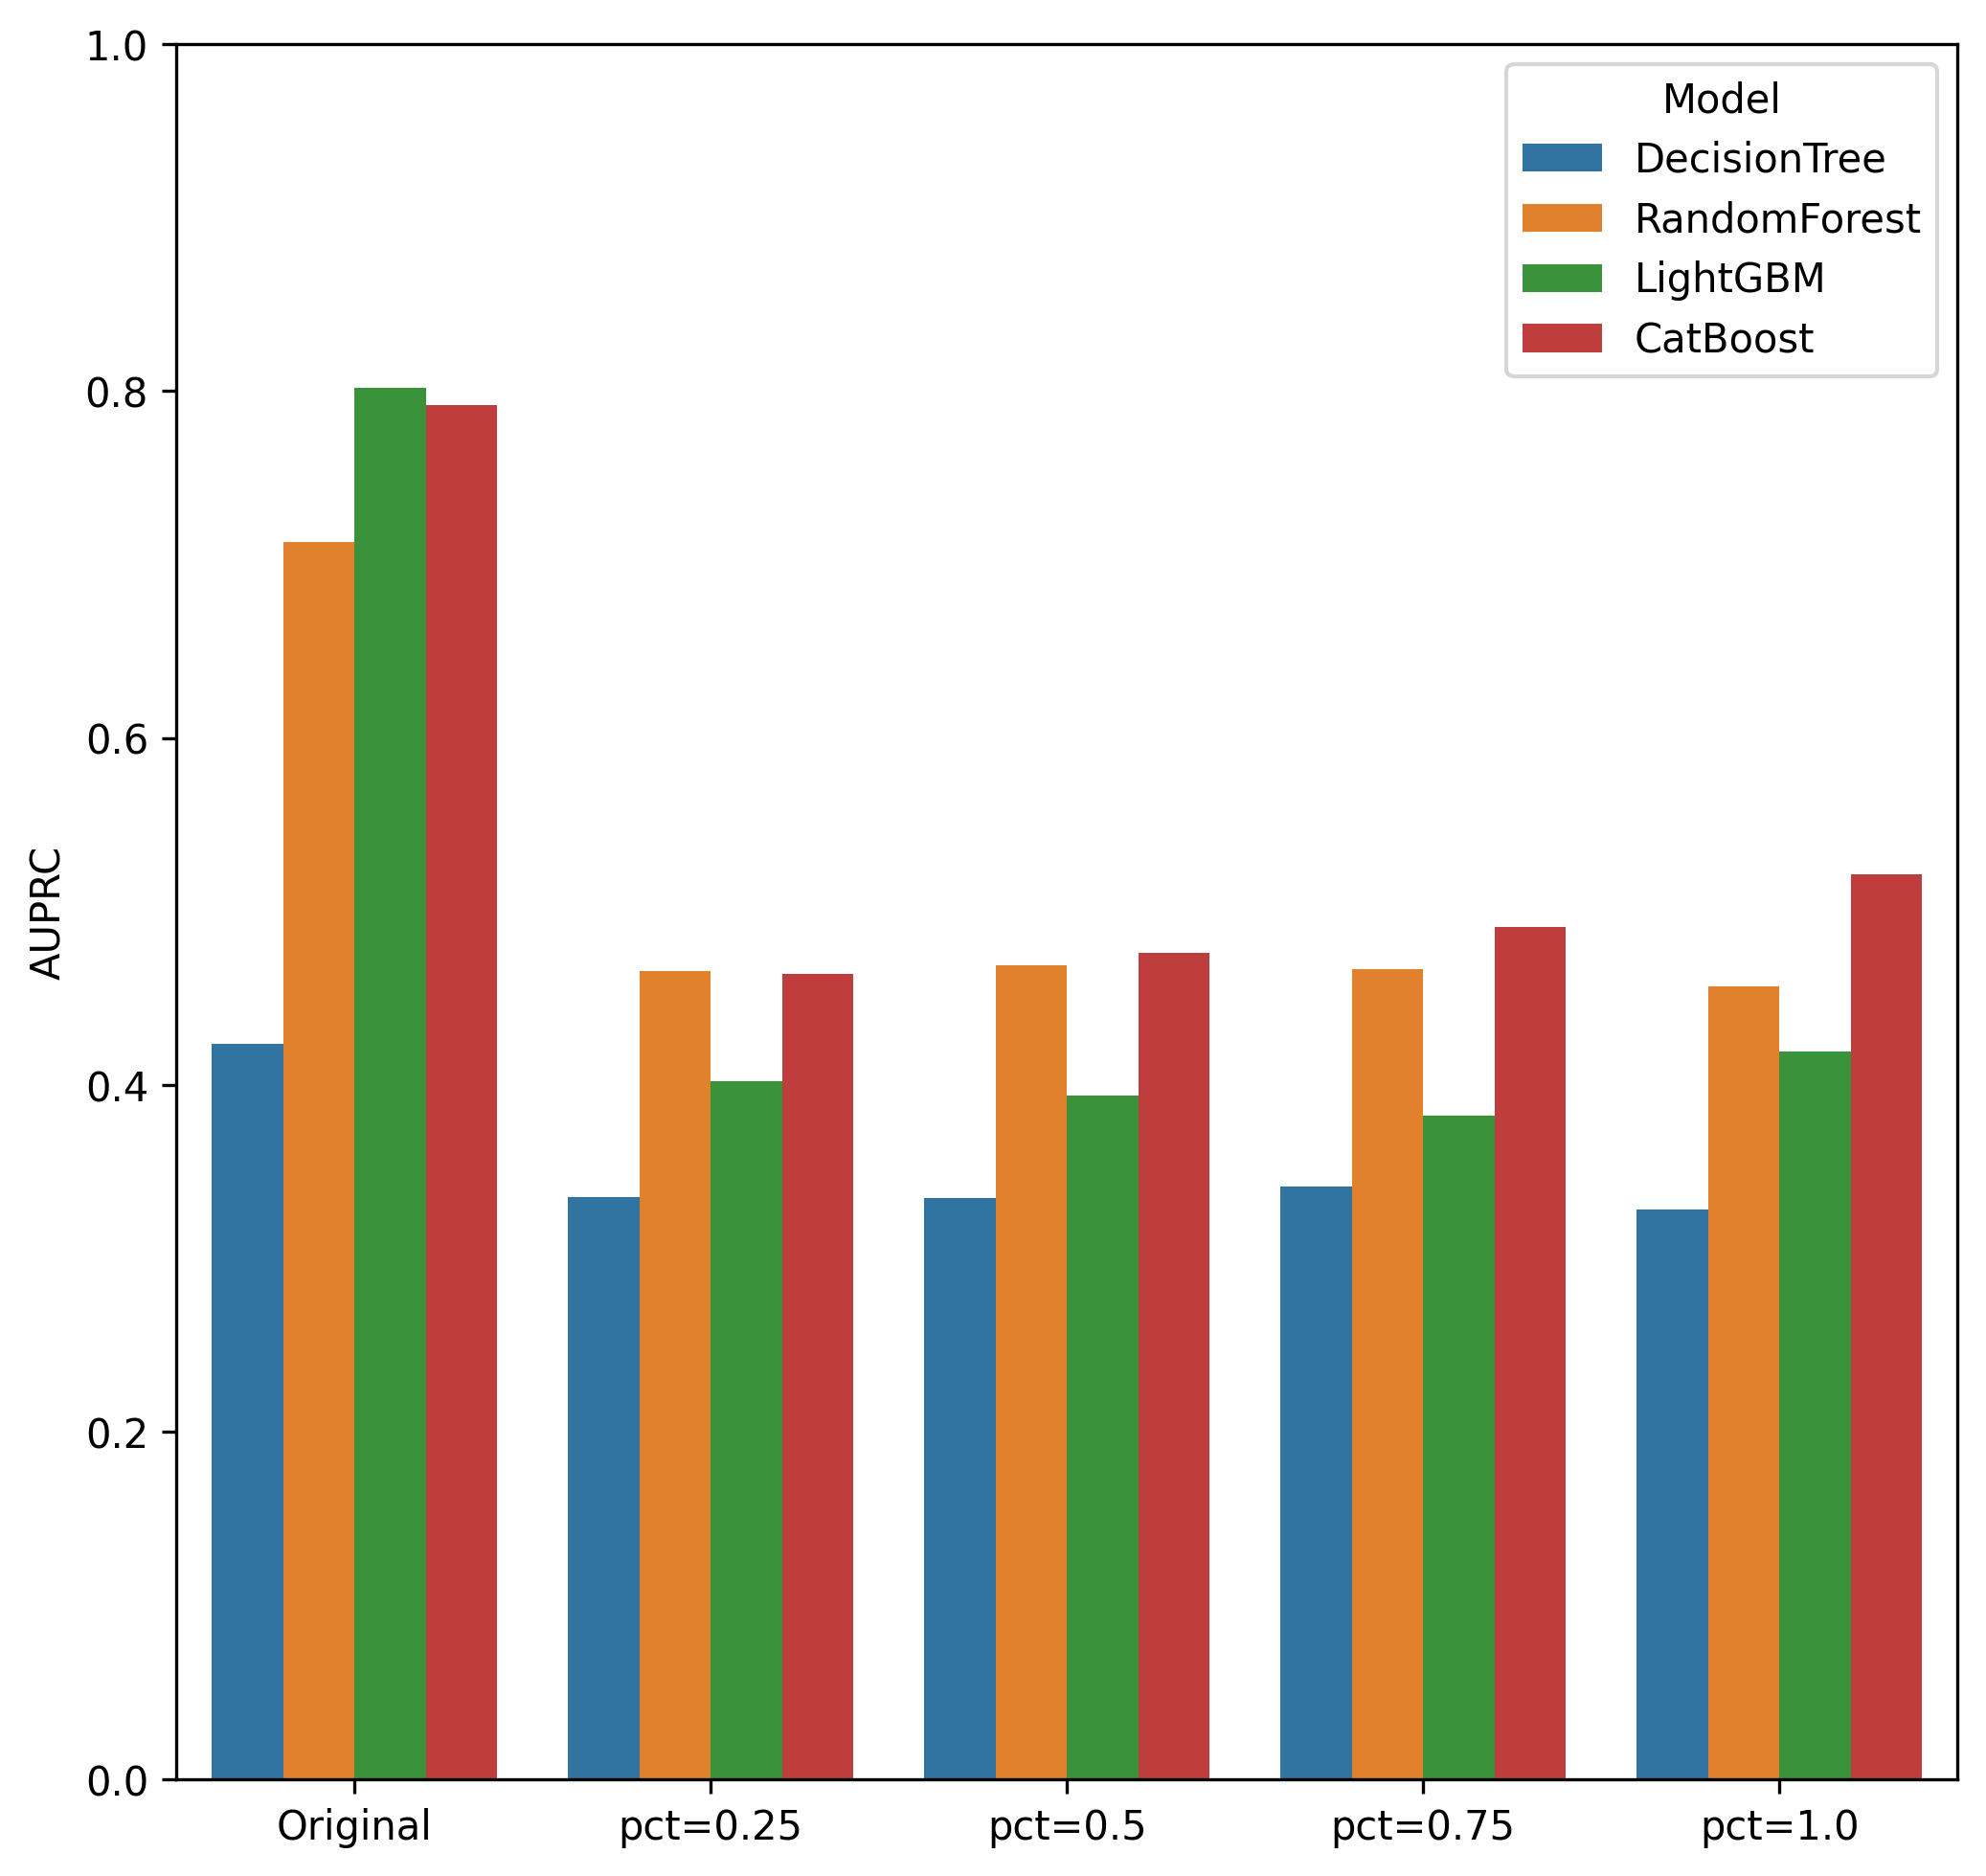

In [33]:
plot_metric(output1, "AUPRC", figsize=(8, 8))

In [34]:
output2 = ml_experiments(
    synthesizer.encoded_X,
    encoded_dataset_msls,
    adult_test_encoded,
    "msl",
    [1, 50, 100, 200],
    n_jobs=n_cores,
)
output2.zen.pretty().format(precision=4)

c:\users\digic\synthbench\.synthbench\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


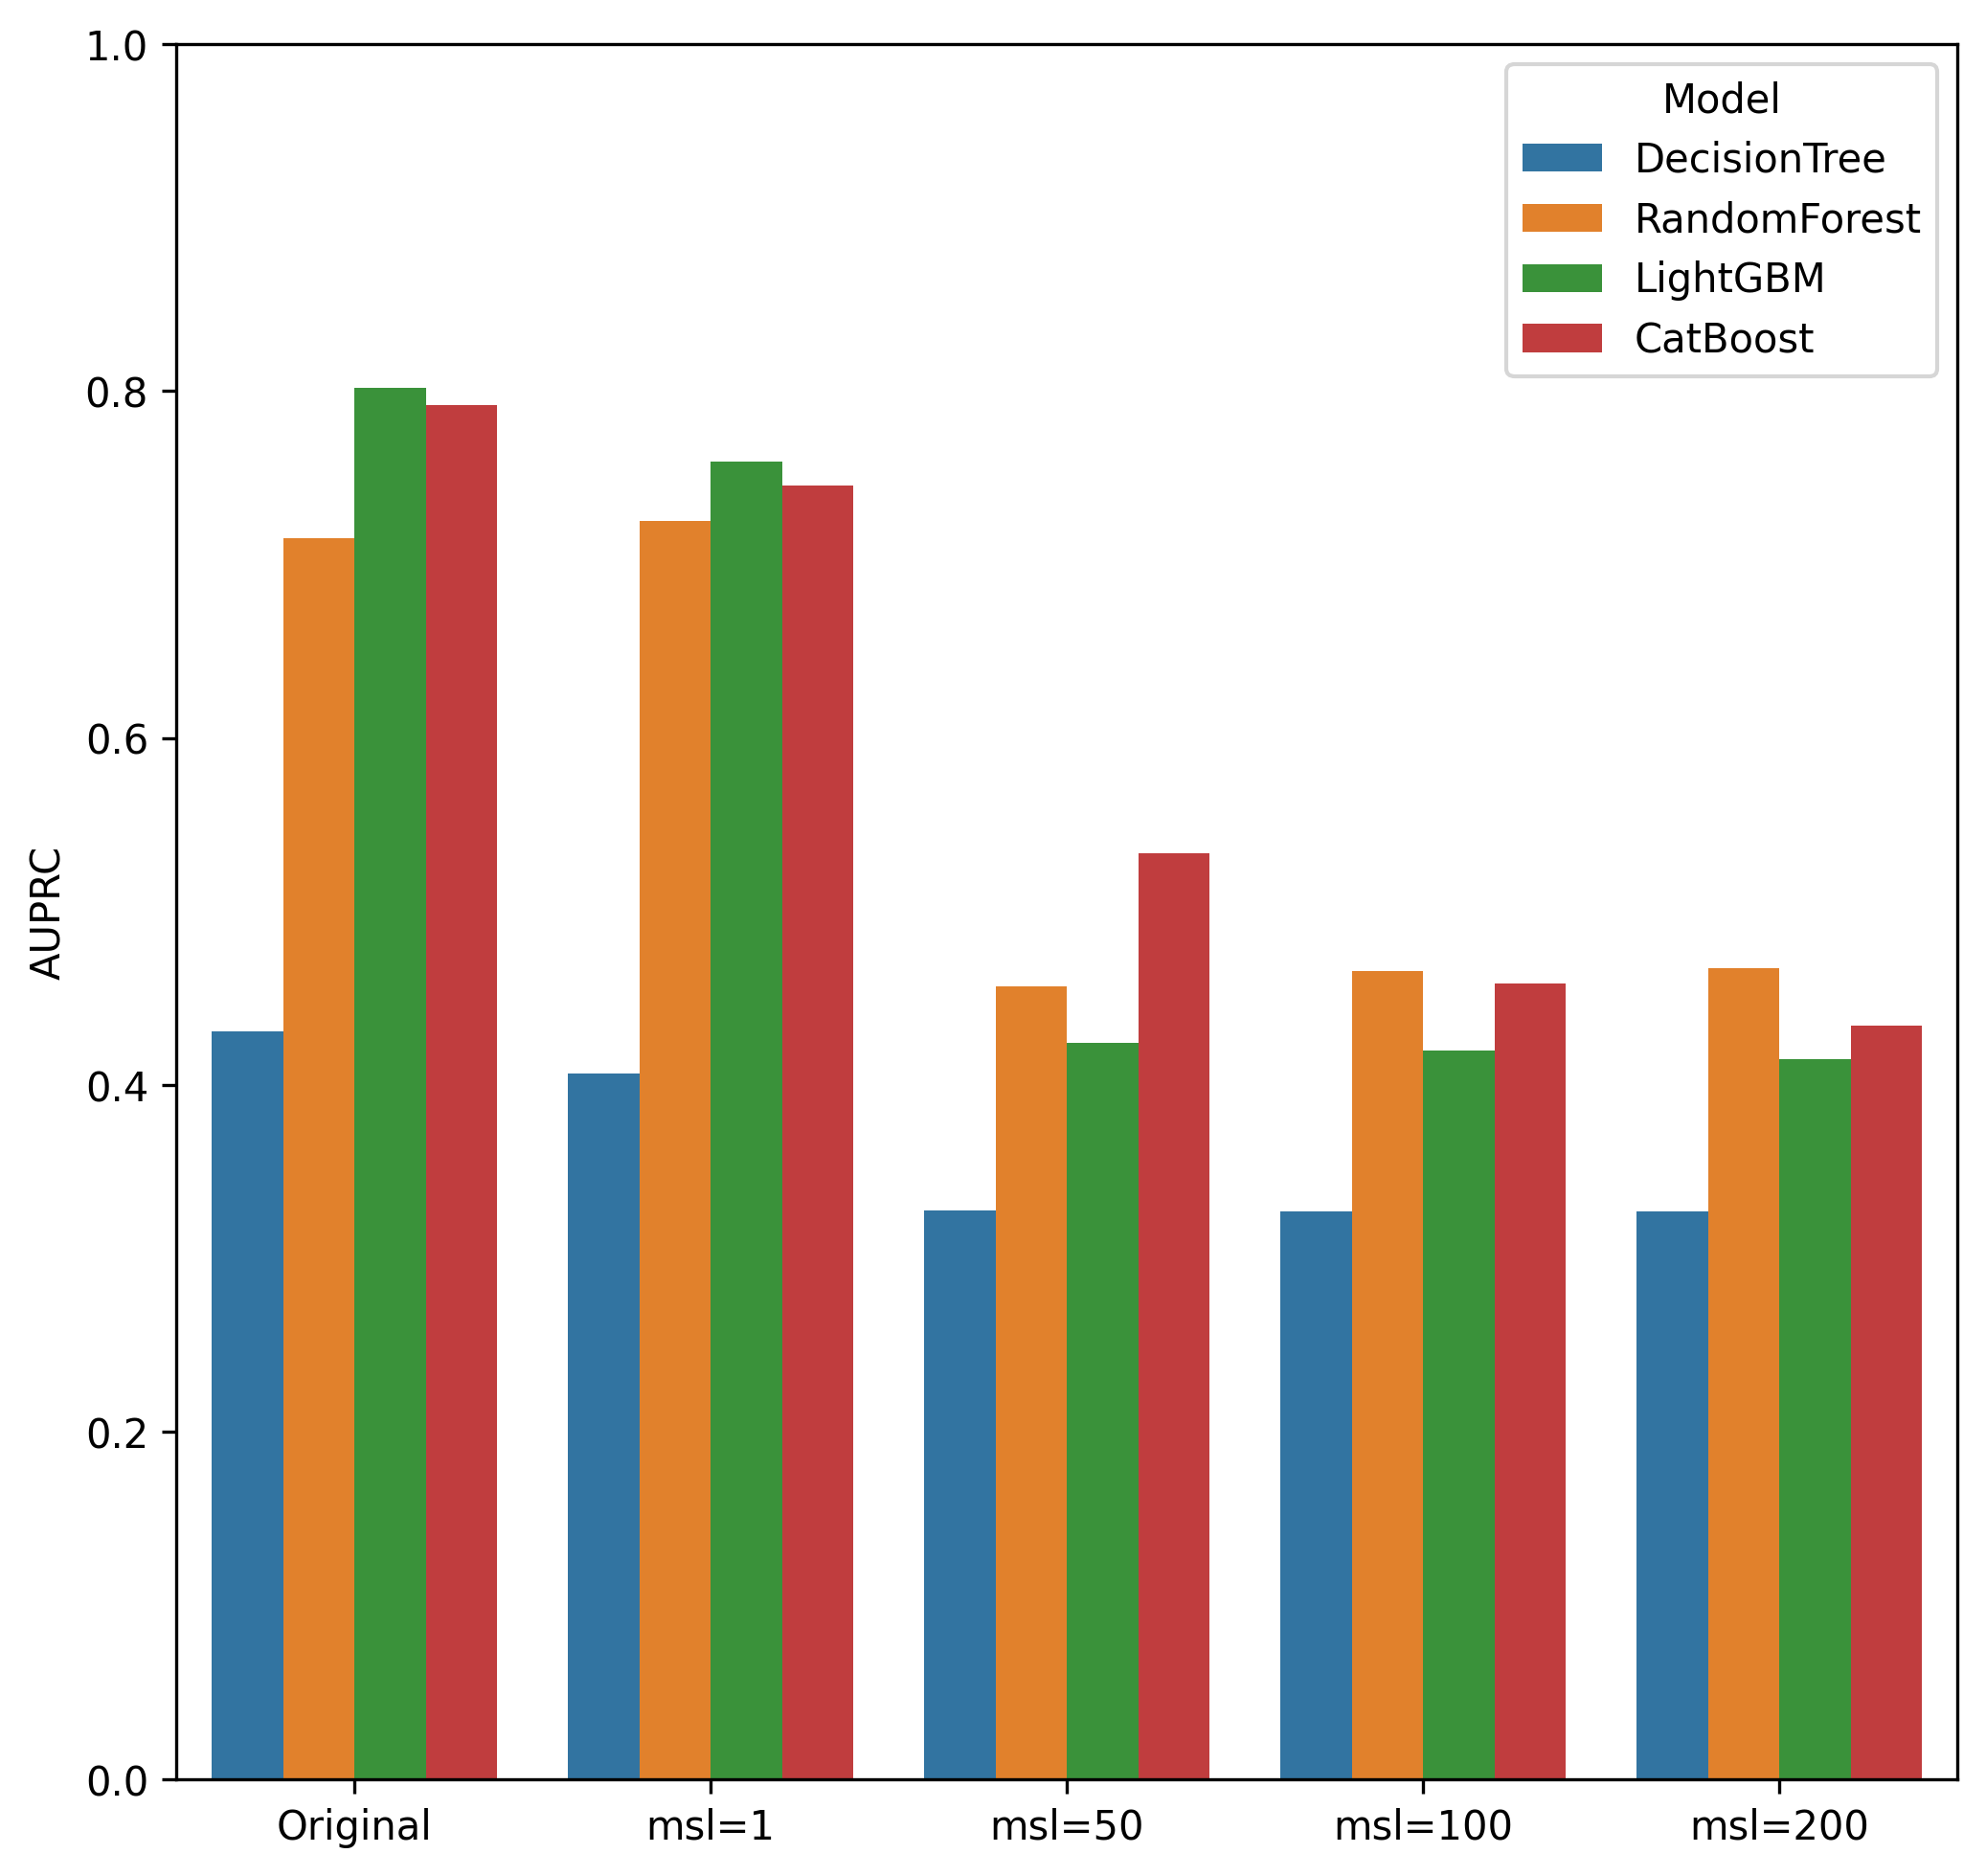

In [35]:
plot_metric(output2, "AUPRC", figsize=(8, 8))

In [36]:
order = [
    "race",
    "workclass",
    "education",
    "marital-status",
    "occupation",
    "relationship",
    "native-country",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
    "income",
]

In [37]:
new_synthesizer = IRSSynthesizer()
new_synthesizer.fit(adult_train, base_cols=["sex", "age"], gen_order=order)

In [38]:
order_dfs = [
    encoded_dataset_pcts[-1],
    Parallel(n_jobs=12)(
        delayed(new_synthesizer.generate)(encode=False, verbose=False)
        for _ in range(10)
    ),
]

In [39]:
output3 = ml_experiments(
    synthesizer.encoded_X,
    order_dfs,
    adult_test_encoded,
    "Order",
    ["default", "y_last"],
    n_jobs=n_cores,
)
output3.zen.pretty().format(precision=4)

c:\users\digic\synthbench\.synthbench\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


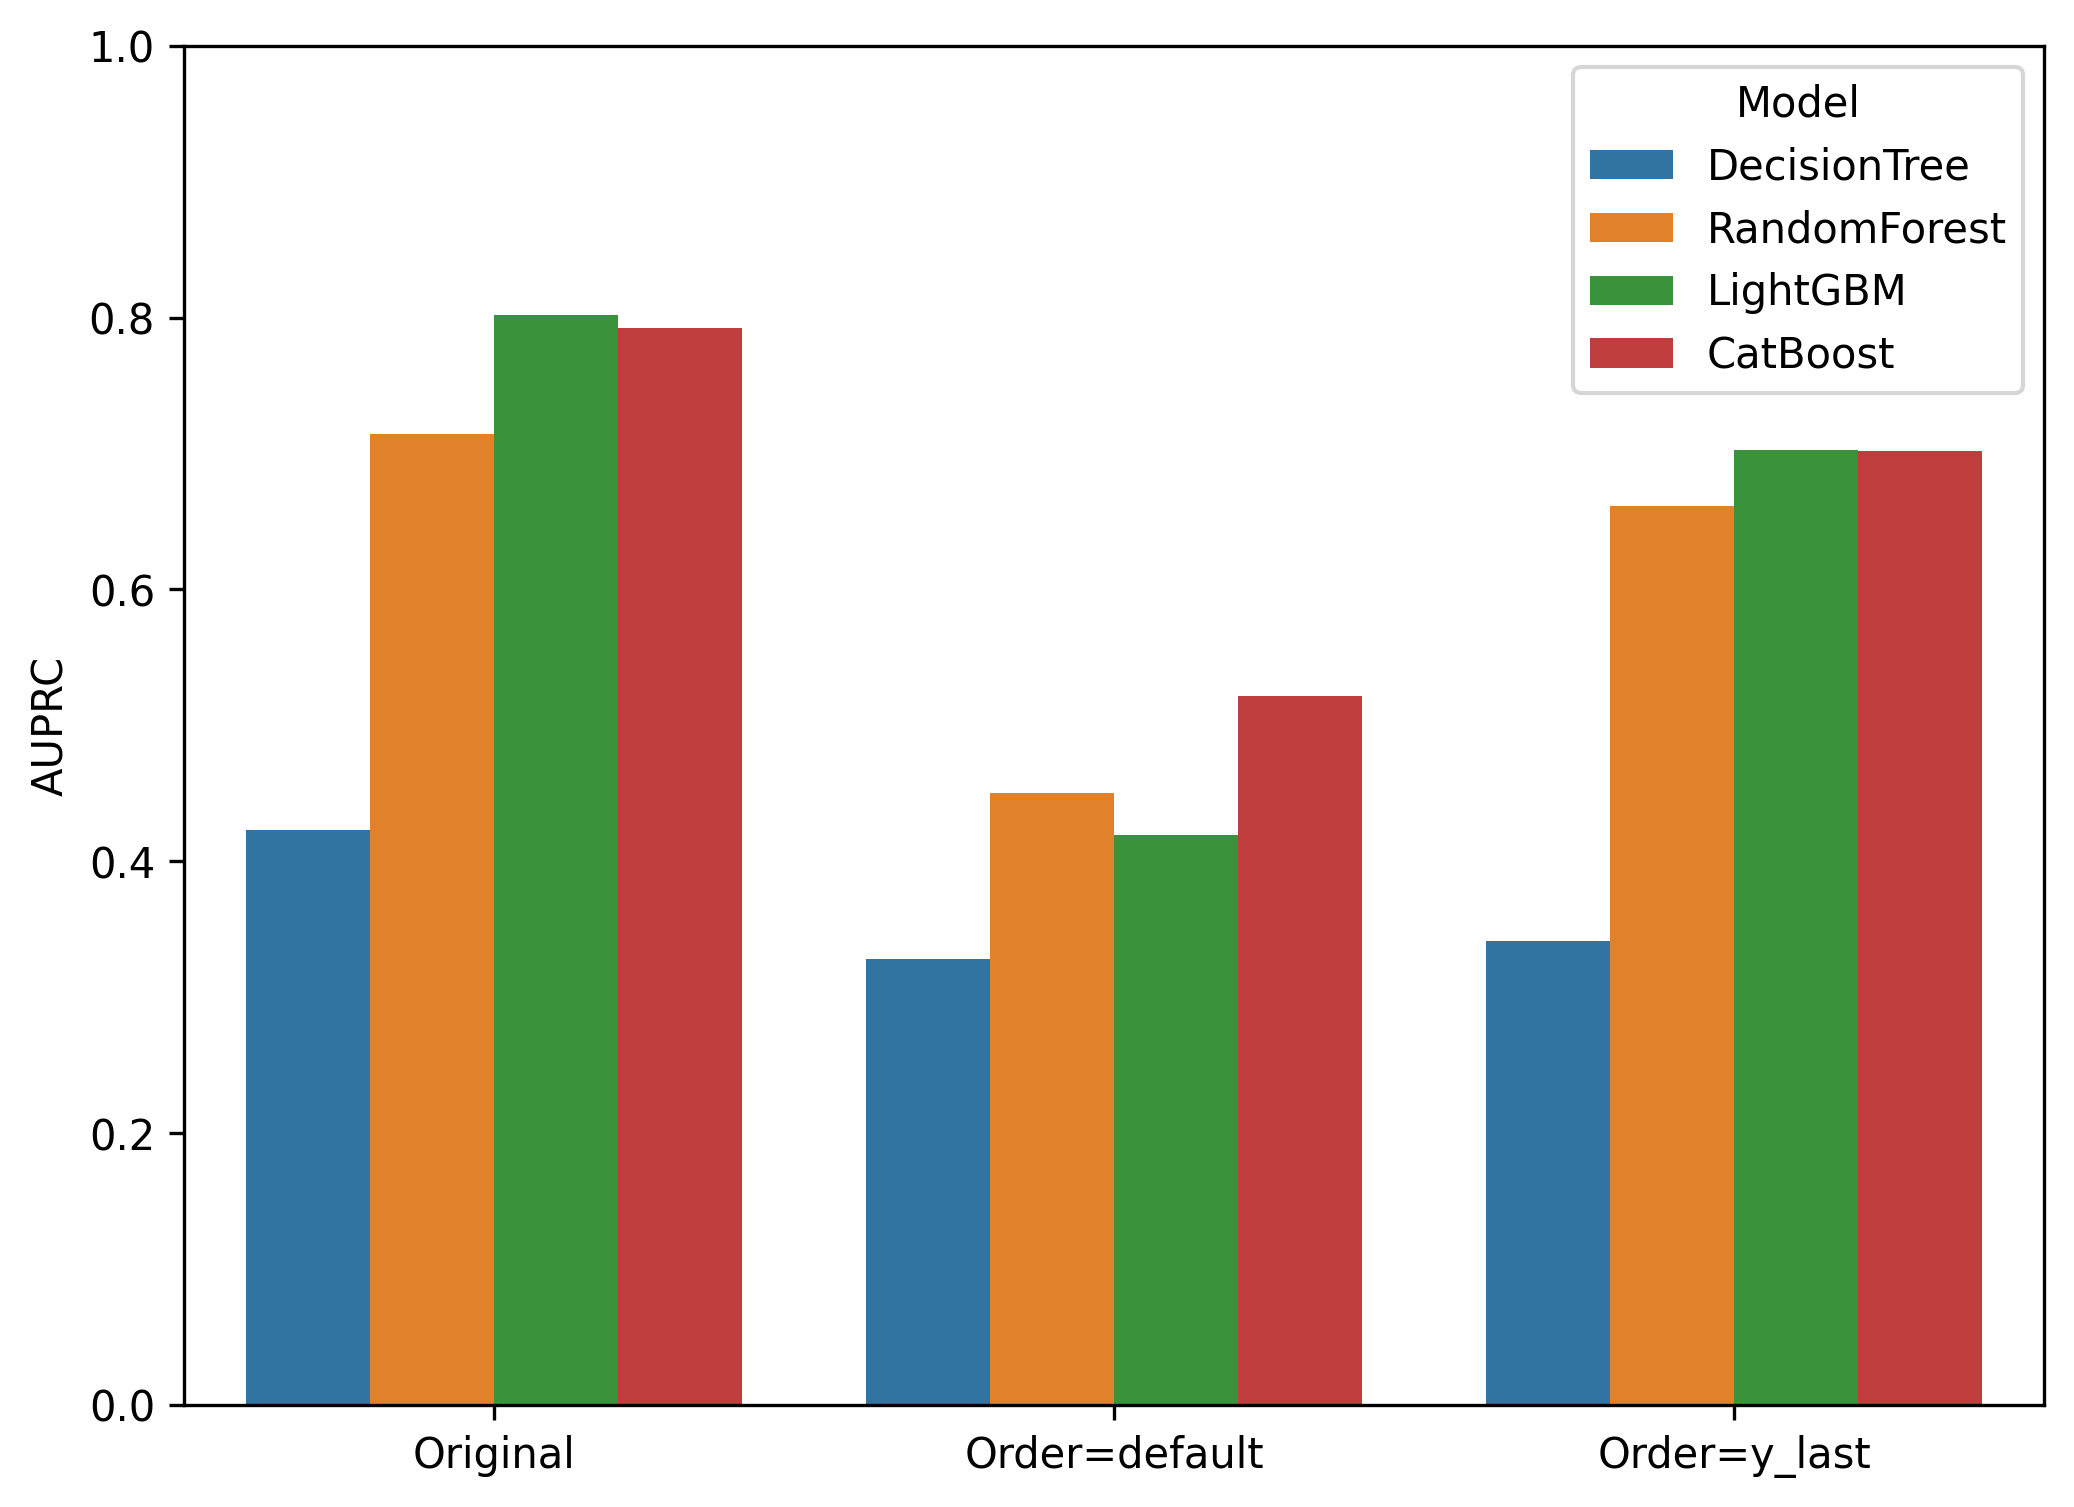

In [40]:
plot_metric(output3, "AUPRC", figsize=(8, 6))

In [41]:
times_table = {}

for size in [10000, 100000, 1000000]:
    times = []

    for _ in range(10):
        start = time.time()
        synthesizer.generate(size=size, verbose=False, encode=False)
        end = time.time()

        times.append(end - start)

    times_table[size] = times

times_table = pd.DataFrame(times_table)

times_table.zen.pretty()

,10000,100000,1000000
0,2.170606,17.025382,163.666502
1,2.225374,16.837250,161.167699
2,2.180636,16.849554,161.101418
3,2.156078,16.841928,162.260417
4,2.160053,16.838398,163.044401
5,2.178423,16.708136,162.769213
6,2.171103,16.610618,162.113569
7,2.168392,16.724522,162.263525
8,2.221058,16.572315,161.512306
9,2.334633,16.800286,161.857325


<AxesSubplot:>

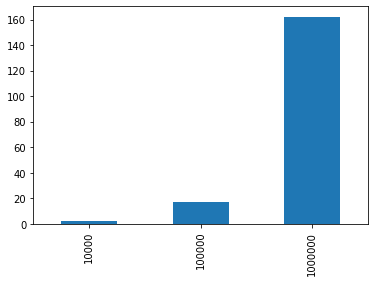

In [42]:
times_table.mean(axis=0).plot.bar()

In [43]:
times_table.mean(axis=0).to_frame().zen.pretty().format(precision=4)

,0
10000,2.1966
100000,16.7808
1000000,162.1756
